In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import os
import time
import numpy as np
import pandas as pd

from utils.comparams import auc
from utils.callbacks import PlotCurves
from utils.preprocess import DataGenerator

import keras
from keras.utils import HDF5Matrix
from keras.optimizers import SGD, Adam
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D 

## Data Generator

In [3]:
# Import dataset
x_train = HDF5Matrix('./data/camelyonpatch_level_2_split_train_x.h5', 'x')
y_train = HDF5Matrix('data/camelyonpatch_level_2_split_train_y.h5', 'y')               
x_valid = HDF5Matrix('data/camelyonpatch_level_2_split_valid_x.h5', 'x')
y_valid = HDF5Matrix('data/camelyonpatch_level_2_split_valid_y.h5', 'y')
x_test = HDF5Matrix('data/camelyonpatch_level_2_split_test_x.h5', 'x')
mask_train = HDF5Matrix('data/camelyonpatch_level_2_split_train_mask.h5', 'mask')

In [4]:
meta_train = pd.read_csv('./data/camelyonpatch_level_2_split_train_meta.csv')
meta_valid = pd.read_csv('./data/camelyonpatch_level_2_split_valid_meta.csv')
meta_test = pd.read_csv('./data/camelyonpatch_level_2_split_test_meta.csv')

In [5]:
limit_data = True
limit = 10000

In [6]:
if limit_data: 
    x_train = x_train[:limit]
    y_train = y_train[:limit]
    x_valid = x_valid[:limit]
    y_valid = y_valid[:limit]

In [7]:
# indexes
train_id = np.arange(len(x_train))
val_id = np.arange(len(x_valid))

# create a useful dictionary structures
partition = {}
partition['train'] = train_id
partition['validation'] = val_id
    
train_labels = {str(i) : y_train[i].flatten()[0] for i in train_id}
val_labels = {str(i) : y_valid[i].flatten()[0] for i in val_id}

## Model

In [8]:
densenet = keras.applications.densenet.DenseNet169(include_top=False, weights='imagenet', input_shape=(224,224,3))

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
x = densenet.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
#x = Dropout(0.5)(x)
y = Dense(2, activation='softmax')(x) # sigmoid instead of softmax to have independent probabilities

model = Model(inputs=densenet.input, outputs=y)

# Train only the top layer
for layer in densenet.layers:
    layer.trainable = False

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

## Compile 

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3,
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

In [14]:
optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999)
loss = 'categorical_crossentropy'
metrics = ['acc', auc]

In [15]:
model.compile(optimizer, loss, metrics)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


## Training

In [16]:
# directory to save the best model
file_dir = './Model'
if not os.path.exists(file_dir):
    os.mkdir(file_dir)
    
model_name = 'DenseNet'
    
network_filepath = os.path.join(file_dir, model_name + '.h5')

In [17]:
def train_network(network, training_generator, validation_generator, n_epoch, network_filepath):
    
    # lists where we will be storing values during training, for visualization purposes
    tra_losses = [] # list for training loss
    tra_accs = [] # list for training accuracy
    val_losses = [] # list for validation loss
    val_accs = [] # list for validation accuracy

    # we want to save the parameters that give the best performance on the validation set
    # therefore, we store the best validation accuracy, and save the parameters to disk
    best_validation_accuracy = 0 # best validation accuracy

    for epoch in range(n_epoch):
        st = time.time()

        # Train your network
        results = network.fit_generator(training_generator)

        # Get training loss and accuracy
        training_loss = results.history['loss']
        training_accuracy = results.history['acc']

        # Add to list
        tra_losses.append(training_loss)
        tra_accs.append(training_accuracy)

        # Evaluate performance (loss and accuracy) on validation set
        scores = network.evaluate_generator(validation_generator)     
        validation_loss = scores[0]
        validation_accuracy = scores[1]

        # Add to list
        val_losses.append(validation_loss)
        val_accs.append(validation_accuracy)

        # (Possibly) update best validation accuracy and save the network
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            network.save(network_filepath)

        # Visualization of the learning curves
        fig = plt.figure(figsize=(10, 5))
        tra_loss_plt, = plt.plot(range(len(tra_losses)), tra_losses, 'b')
        tra_accs_plt, = plt.plot(range(len(tra_accs)), tra_accs, 'c')
        val_loss_plt, = plt.plot(range(len(val_losses)), val_losses, 'g')
        val_acc_plt, = plt.plot(range(len(val_accs)), val_accs, 'r')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend([tra_loss_plt, tra_accs_plt, val_loss_plt, val_acc_plt], 
                  ['training loss', 'training accuracy', 'validation loss', 'validation accuracy'],
                  loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title('Best validation accuracy = {:.2f}%'.format(100. * best_validation_accuracy))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(.2)

In [18]:
# Define batch size.
'''batch_size = 32
n_epoch = 5

# Parameters for generators
params = {
    'dim': (224, 224),
    'batch_size': batch_size,
    'n_classes': 2,
    'shuffle': True
}

# Generators
training_generator = DataGenerator(partition['train'], x_train, train_labels, **params)
validation_generator = DataGenerator(partition['validation'], x_valid, val_labels, **params)'''

"batch_size = 32\nn_epoch = 5\n\n# Parameters for generators\nparams = {\n    'dim': (224, 224),\n    'batch_size': batch_size,\n    'n_classes': 2,\n    'shuffle': True\n}\n\n# Generators\ntraining_generator = DataGenerator(partition['train'], x_train, train_labels, **params)\nvalidation_generator = DataGenerator(partition['validation'], x_valid, val_labels, **params)"

In [19]:
# Train the model 
#train_network(model, training_generator, validation_generator, n_epoch, network_filepath)

In [20]:
# Define batch size.
batch_size = 128
n_epoch = 10
# time_limit = 500 # time limit in minute (500 -> 8 hrs and 20 min)

# Parameters for generators
params = {
    'dim': (224, 224),
    'batch_size': batch_size,
    'n_classes': 2,
    'shuffle': True
}

# Generators
training_generator = DataGenerator(partition['train'], x_train, train_labels, **params)
validation_generator = DataGenerator(partition['validation'], x_valid, val_labels, **params)

#a function to save last_model compatible with the on_interrupt handler of TimerCallback
def saveWeights(model, elapsed):
    model.save_weights(os.path.join(file_dir, model_name + '_weights.h5'))


# Callbacks,
callbacks = [PlotCurves(), learning_rate_reduction]#, TimerCallback(1, on_interrupt=saveWeights)]
#roc_callback(training_data=training_generator,validation_data=validation_generator)

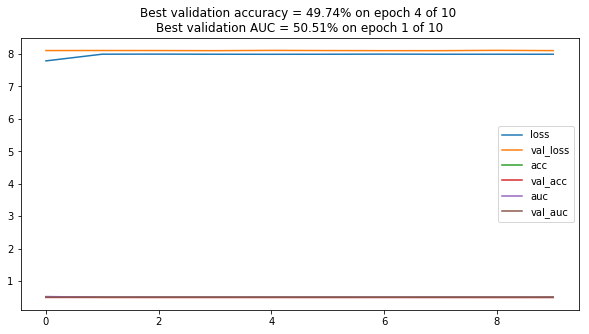


Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.


In [21]:
# Training with ...
model.fit_generator(training_generator, validation_data=validation_generator, 
                    epochs=n_epoch, callbacks=callbacks)

In [22]:
model.save(network_filepath)

<Figure size 720x360 with 0 Axes>

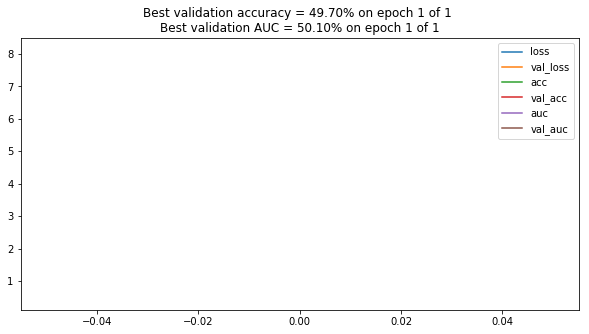

Epoch 2/10
67/78 [========================>.....] - ETA: 2:15 - loss: 8.0290 - acc: 0.5019 - auc: 0.5009

KeyboardInterrupt: 

In [23]:
# Training with 10k
model.fit_generator(training_generator, validation_data=validation_generator, 
                    epochs=n_epoch, callbacks=callbacks)